In [1]:
import torch
import numpy as np
import os
from model_lorentz import GPTConfig, GPT

root_dir = "/raid/tinystories-ckpts"  # Adjust this path if necessary

# Get a list of all experiment folders
ckpt_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)]

ckpt_dirs = ckpt_dirs[0]
[os.path.join(ckpt_dirs, d) for d in os.listdir(ckpt_dirs)]

['/raid/tinystories-ckpts/evo_ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_384_max_lr_0.0006_min_lr_1e-05_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_4_18.33/40k.pt',
 '/raid/tinystories-ckpts/evo_ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_384_max_lr_0.0006_min_lr_1e-05_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_4_18.33/10k.pt',
 '/raid/tinystories-ckpts/evo_ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_384_max_lr_0.0006_min_lr_1e-05_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_4_18.33/90k.pt',
 '/raid/tinystories-ckpts/evo_ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_384_max_lr_0.0006_min_lr_1e-05_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_4_18.33/30k.pt',
 '/raid/tinystories-ckpts/evo_ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_384_max_lr_0.0006_min_lr_1e-05_lr_decay_iters_100000_batch_size_1_gradient_a

In [2]:
c_dict = {}
for i in range(10, 110, 10):
    checkpoint_path = os.path.join(ckpt_dirs, f"{i}k.pt")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    state_dict = checkpoint['model']
    cs_list = []
    for k in state_dict.keys():
        if k.endswith('attn.c'):
            cs = state_dict[k].flatten().numpy()
            cs_list.append(cs)
    c_dict[f"{i}k iters"] = np.array(cs_list)


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hists_with_kde(data_list, title, bins=8, figsize=(8, 12), height_ratios=None, add_kde=True):
    
    n_plots = len(data_list)
    
    # Calculate the means of each dataset in data_list
    means = np.array([data.mean() for data in data_list])

    # Normalize the means to get values between 0 and 1 (for color mapping)
    normalized_means =  (means - means.min()) / (means.max() - means.min())

    # Generate a dark palette for colors
    palette = sns.dark_palette("seagreen", as_cmap=True)

    # Define height ratios for the subplots to create oblate shapes (short but wide histograms)
    if height_ratios is None:
        height_ratios = [1] * n_plots  # Equal height for each plot
    
    # Create a figure and subplots
    fig, axes = plt.subplots(n_plots, 1, figsize=figsize, gridspec_kw={'height_ratios': height_ratios}, sharex=True)
    
    # If there's only one plot, wrap the axes object in a list
    if n_plots == 1:
        axes = [axes]
    
    # Create histograms for each dataset
    for i, (ax, data, norm_mean) in enumerate(zip(axes, data_list, normalized_means)):
        # Get color based on the normalized mean
        color = palette(norm_mean)
        mean, std = data.mean(), data.std()
        
        # Plot the histogram
        sns.histplot(data, bins=bins, ax=ax, kde=False, stat='density',
                     color=color, edgecolor='black', alpha=0.6)
        
        if add_kde:
            # Plot the KDE
            sns.kdeplot(data, ax=ax, color=color, lw=2, bw_adjust=0.2)
        
        # Add title, legend, and labels
        ax.set_ylabel(f'Head {i+1}')
        ax.legend([f"Head {i+1}: c = {mean:.2f} ± {std:.2f}"], loc='upper right')

    # Set shared x-label
    plt.xlabel('Value')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

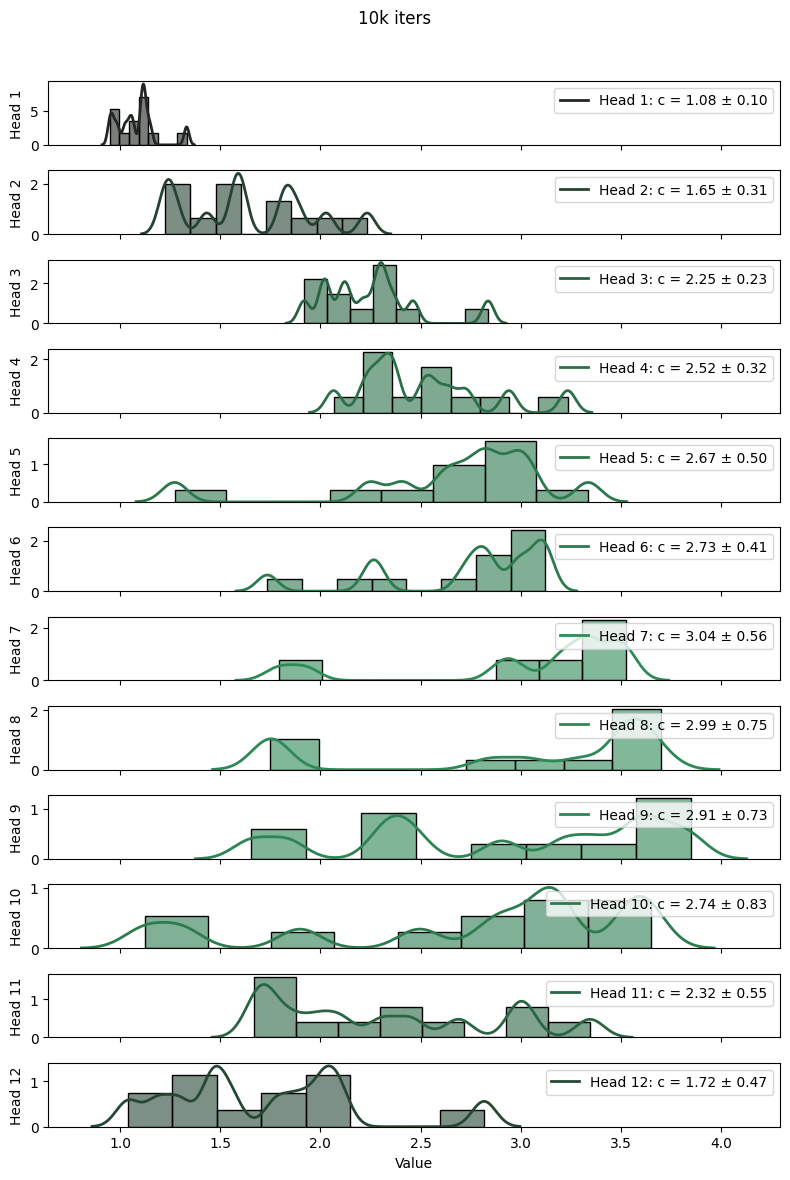

In [60]:
for title, curvs in c_dict.items():
    plot_hists_with_kde(curvs, title)
    break

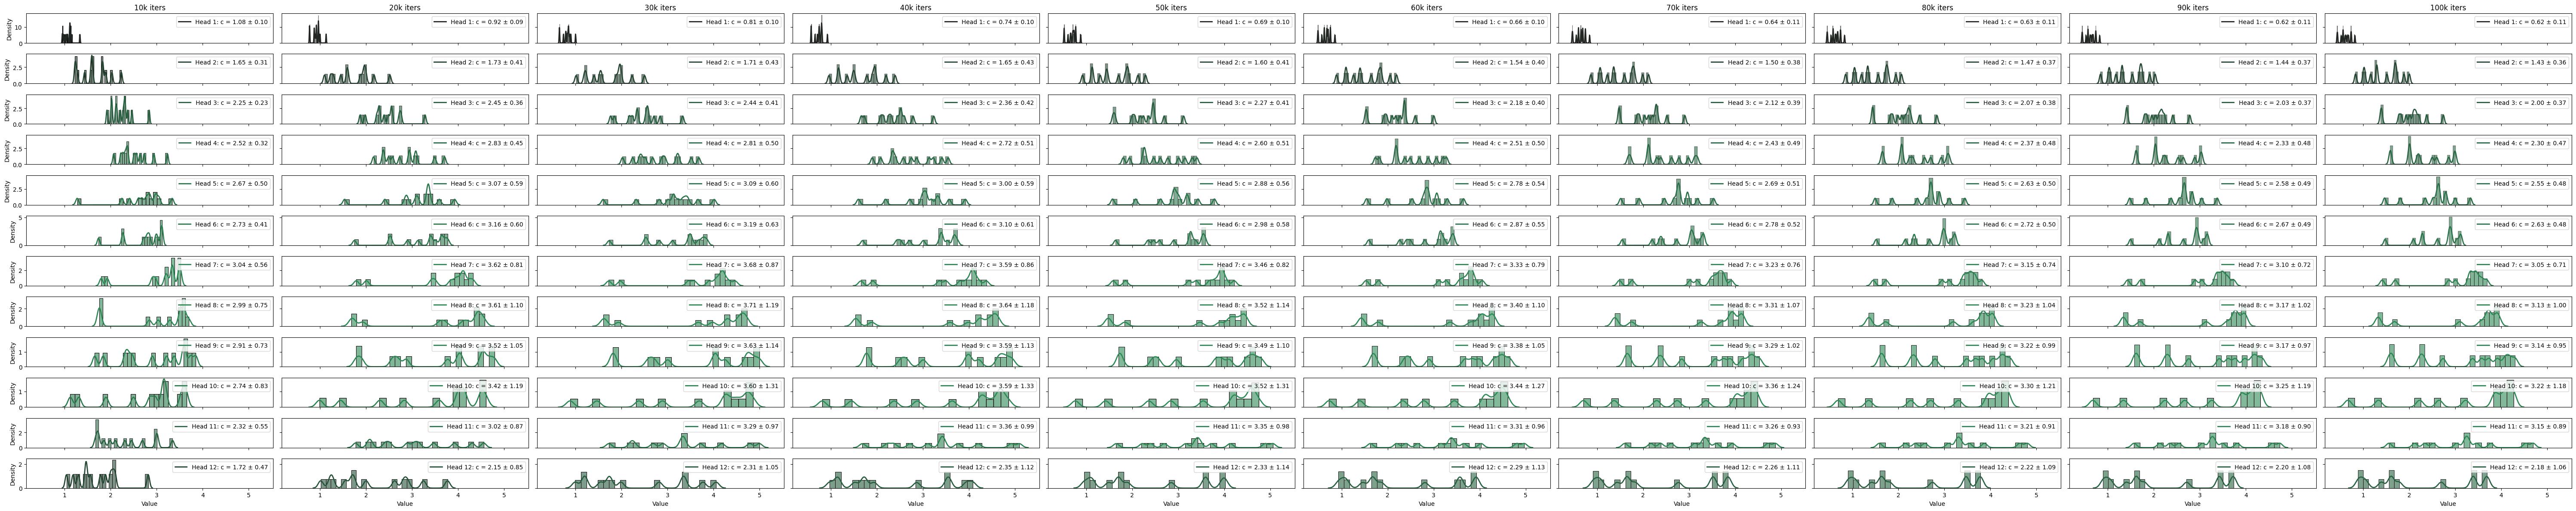

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define your plotting function that creates a column of histograms
def plot_hists_with_kde_2(ax, data_list, bins=8, add_kde=True, bw_adjust=0.2):
    n_plots = len(data_list)
    
    # Calculate the means of each dataset in data_list
    means = np.array([data.mean() for data in data_list])
    
    # Normalize the means to get values between 0 and 1 (for color mapping)
    normalized_means = (means - means.min()) / (means.max() - means.min())
    
    # Generate a dark palette for colors
    palette = sns.dark_palette("seagreen", as_cmap=True)
    
    # Create histograms for each dataset
    for i, (data, norm_mean) in enumerate(zip(data_list, normalized_means)):
        # Get color based on the normalized mean
        color = palette(norm_mean)
        mean, std = data.mean(), data.std()
        
        # Plot the histogram on the i-th subplot (vertical alignment)
        sns.histplot(data, bins=bins, ax=ax[i], kde=False, stat='density',
                     color=color, edgecolor='black', alpha=0.6)
        
        if add_kde:
            # Plot the KDE
            sns.kdeplot(data, ax=ax[i], color=color, lw=2, bw_adjust=bw_adjust)
        
        # Add a label to each histogram
        ax[i].legend([f"Head {i+1}: c = {mean:.2f} ± {std:.2f}"], loc='upper right')
    
    # Set shared xlabel for the last plot in the column
    ax[-1].set_xlabel('Value')

# Main function to plot multiple sets as columns of histograms
def plot_dict_of_hists(data_dict, bins=8, figsize=(16, 12), add_kde=True, bw_adjust=0.2):
    n_cols = len(data_dict)
    n_rows = len(next(iter(data_dict.values())))  # Assume all lists have the same number of elements
    
    # Create a grid with `n_rows` rows and `n_cols` columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey='row')
    
    # Ensure axes are iterable (when you have a single row/column)
    if n_cols == 1:
        axes = [axes]
    if n_rows == 1:
        axes = [axes]
    
    # Loop through the dictionary and create a column of histograms for each key
    for col_idx, (key, data_list) in enumerate(data_dict.items()):
        # Plot histograms in each column using the `plot_hists_with_kde_2` function
        plot_hists_with_kde_2(axes[:, col_idx], data_list, bins=bins, add_kde=add_kde, bw_adjust=bw_adjust)
        
        # Set the title for each column based on the dictionary key
        axes[0, col_idx].set_title(key)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
# data_dict = {
#     'Set A': [np.random.normal(loc=0, scale=1, size=100) for _ in range(12)],
#     'Set B': [np.random.normal(loc=2, scale=1.5, size=100) for _ in range(12)],
#     'Set C': [np.random.normal(loc=-1, scale=0.5, size=100) for _ in range(12)]
# }

# Plot the data in the dictionary
plot_dict_of_hists(c_dict, bins=25, figsize=(60, 12), add_kde=True, bw_adjust=0.1)

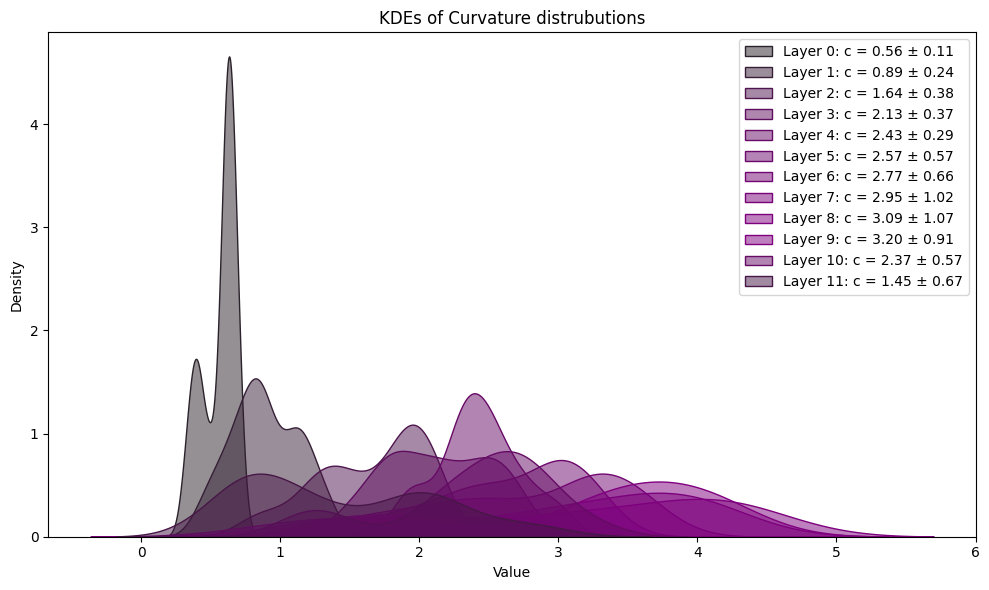

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the means of each row in cs
means = np.array([c.mean() for c in cs])

# Normalize the means to get values between 0 and 1 (for color mapping)
normalized_means = (means - means.min()) / (means.max() - means.min())

# Generate a dark palette, and assign colors based on the normalized means
palette = sns.dark_palette("purple", as_cmap=True)  # Using 'purple' as a base color

# Create the plot
plt.figure(figsize=(10, 6))

# Loop over each row in cs and plot its histogram
for i, (c, norm_mean) in enumerate(zip(cs, normalized_means)):
    mean = c.mean()
    std = c.std()
    
    # Convert the normalized mean to an actual color from the palette
    color = palette(norm_mean)
    
    # Plot the histogram with transparency alpha=0.5 and color depending on the mean
    # plt.hist(c, bins=10, alpha=0.5, label=f"Layer {i}: c = {mean:.2f} ± {std:.2f}", color=color)
    sns.kdeplot(c, fill=True, color=color, alpha=0.5, label=f"Layer {i}: c = {mean:.2f} ± {std:.2f}", common_norm=False, bw_adjust=0.7)


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('KDEs of Curvature distrubutions')

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [4]:
for i, block in enumerate(model.transformer.h):
    for name, param in block.named_parameters():
        print(f"Name: {name} | Shape: {param.shape} | Requires Grad: {param.requires_grad}")
    break

Name: ln_1.weight | Shape: torch.Size([384]) | Requires Grad: True
Name: attn.c | Shape: torch.Size([1, 12, 1, 1]) | Requires Grad: True
Name: attn.c_attn.weight | Shape: torch.Size([1152, 384]) | Requires Grad: True
Name: attn.c_proj.weight | Shape: torch.Size([384, 384]) | Requires Grad: True
Name: ln_2.weight | Shape: torch.Size([384]) | Requires Grad: True
Name: mlp.c_fc.weight | Shape: torch.Size([1536, 384]) | Requires Grad: True
Name: mlp.c_proj.weight | Shape: torch.Size([384, 1536]) | Requires Grad: True


In [2]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# Define the path to your root logs directory
root_log_dir = "/raid/runs_train/10.05"  # Adjust this path if necessary

# Get a list of all experiment folders
log_dirs = [os.path.join(root_log_dir, d) for d in os.listdir(root_log_dir)]

log_dirs

['/raid/runs_train/10.05/cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_384_learning_rate_0.0003_min_lr_3e-06_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_4_22.08',
 '/raid/runs_train/10.05/mode_original_n_layer_12_n_head_12_n_embd_384_learning_rate_0.0003_min_lr_3e-06_lr_decay_iters_100000_batch_size_4_gradient_accumulation_steps_1_15.21']

In [30]:
log_dirs_bs1 = [log_dirs[0], log_dirs[2]]
log_dirs_bs2 = [log_dirs[1], log_dirs[2]]
log_dirs_o = log_dirs[:4]
log_dirs_l = log_dirs[4:]

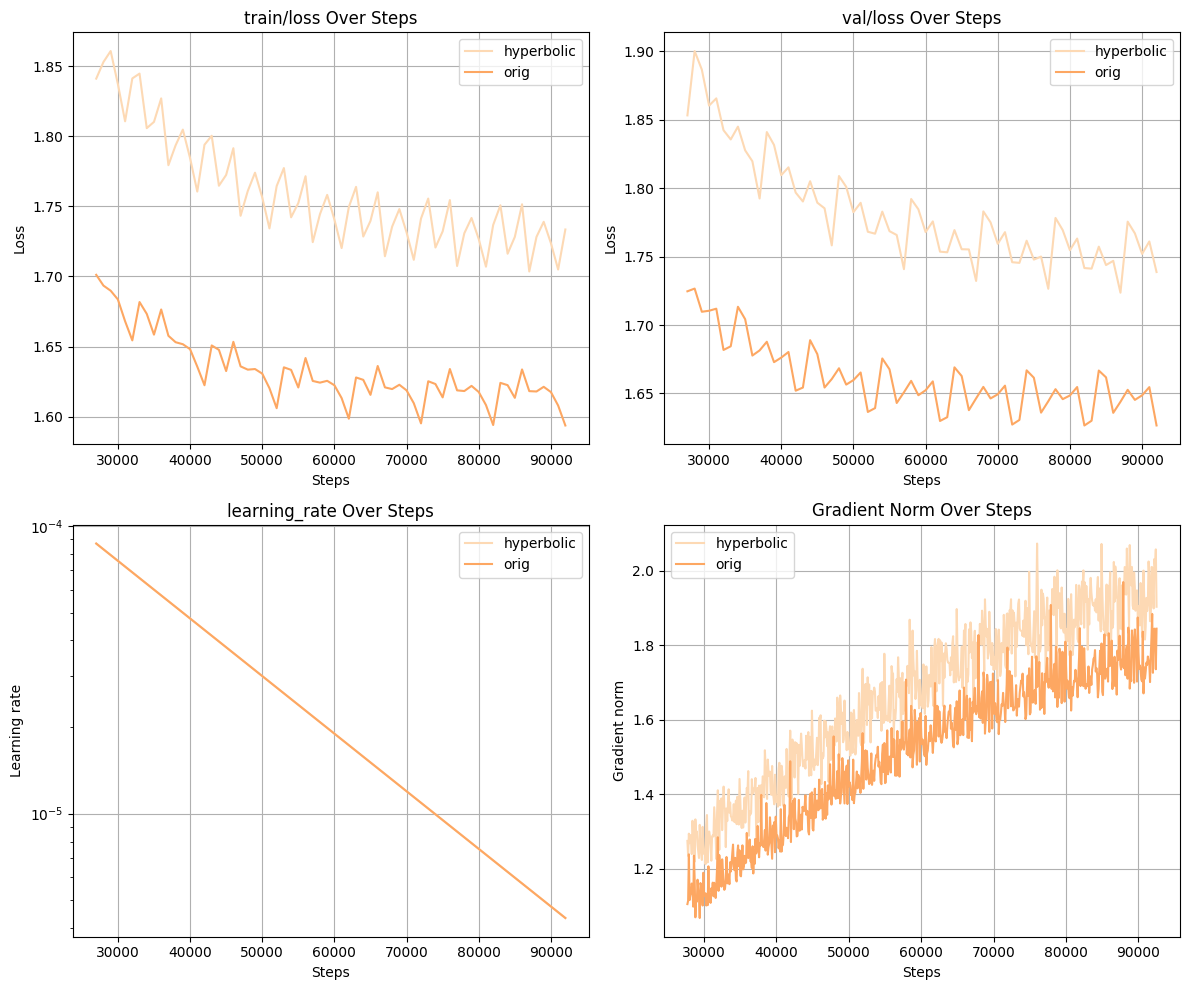

In [14]:
logs_to_show=log_dirs
# exp_names = [n[23:36] for n in logs_to_show]
exp_names = ['hyperbolic', 'orig']

# Initialize a dictionary to hold data for each experiment
experiment_data = {}

for log_dir in logs_to_show:
    # Load TensorBoard logs
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Get available scalar tags (train/loss, val/loss, learning_rate, Gradient Norm)
    tags = ['train/loss', 'val/loss', 'learning_rate', 'Gradient Norm']
    
    # Extract and store scalar values for each tag
    data = {}
    for tag in tags:
        if tag in event_acc.Tags().get('scalars', []):  # Check if tag is available
            scalars = event_acc.Scalars(tag)
            steps = [s.step for s in scalars]
            values = [s.value for s in scalars]
            data[tag] = {'steps': steps, 'values': values}
    
    # Store the extracted data for this experiment folder
    experiment_data[os.path.basename(log_dir)] = data


metrics = ['train/loss', 'val/loss', 'learning_rate', 'Gradient Norm']

# exp_names = ['hyperbolic c=1e-5', 'original']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid

# Flatten the axs array for easy iteration
axs = axs.ravel()

# Loop over each metric and create a plot
for i, metric in enumerate(metrics):
    ax = axs[i]
    boo = True
    
    for (experiment, data), e in zip(experiment_data.items(), exp_names):
        if metric in data:
            if boo:
                length = len(data[metric]['steps'])
                boo = False
            from_, to_ = int(0.3*length), int(1*length)
            steps = data[metric]['steps'][from_:to_]
            values = data[metric]['values'][from_:to_]
            ax.plot(steps, values, label=e)
    
    if 'learning' in metric:
        ax.set_yscale('log')  
    ax.set_xlabel('Steps')
    # ax.set_xlim([0, 1.1*max(steps)])
    ax.set_ylabel(metric.split('/')[-1].replace('_', ' ').capitalize())  # Clean y-axis label
    ax.set_title(f'{metric} Over Steps')
    ax.grid(True)  # Add grid
    ax.legend()

plt.tight_layout()
# plt.savefig('runs_head.jpg')
plt.show()

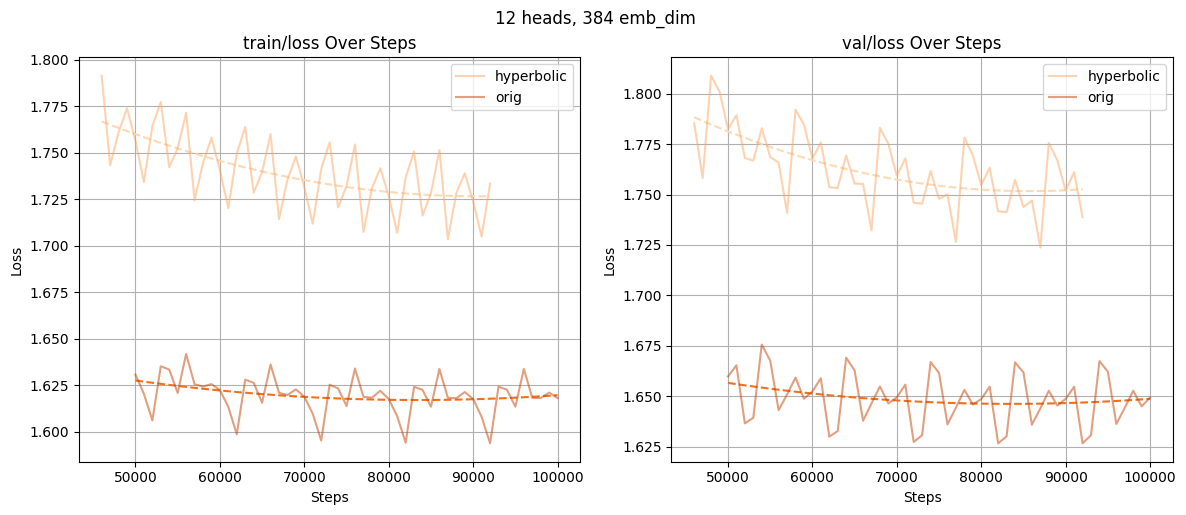

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import os
import seaborn as sns

# Set the Seaborn color palette
palette = sns.color_palette("Oranges", n_colors=4)  # husl, deep, bright, etc.
plt.rc('axes', prop_cycle=plt.cycler('color', palette))

# Function to fit a parabola and plot
def fit_and_plot_parabola(ax, steps, values, label):
    # Fit a quadratic function (parabola)
    coefs = np.polyfit(steps, values, 2)  # 2 for quadratic fit
    poly = np.poly1d(coefs)
    
    # Generate points for plotting the parabola
    fitted_values = poly(steps)
    
    # Plot the fitted parabola
    ax.plot(steps, fitted_values, linestyle='--') #label=f'{label} quadratic fit'
    
    # Find the minimum of the parabola
    min_step = -coefs[1] / (2 * coefs[0])
    min_value = poly(min_step)
    
    # Highlight the minimum point
    ax.scatter(min_step, min_value, color='red', zorder=5)
    
    return min_step, min_value

# Filter logs to only show train/loss and val/loss
logs_to_show = log_dirs
# exp_names = [n[23:36] for n in logs_to_show]
exp_names = ['hyperbolic', 'orig']

# Initialize a dictionary to hold data for each experiment
experiment_data = {}

for log_dir in logs_to_show:
    # Load TensorBoard logs
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    # Get available scalar tags (train/loss, val/loss)
    tags = ['train/loss', 'val/loss']

    # Extract and store scalar values for each tag
    data = {}
    for tag in tags:
        if tag in event_acc.Tags().get('scalars', []):  # Check if tag is available
            scalars = event_acc.Scalars(tag)
            steps = [s.step for s in scalars]
            values = [s.value for s in scalars]
            data[tag] = {'steps': steps, 'values': values}

    # Store the extracted data for this experiment folder
    experiment_data[os.path.basename(log_dir)] = data

metrics = ['train/loss', 'val/loss']  # Only include loss metrics

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 grid

# Flatten the axs array for easy iteration
axs = axs.ravel()

# Loop over each metric and create a plot
for i, metric in enumerate(metrics):
    ax = axs[i]
    
    for (experiment, data), e in zip(experiment_data.items(), exp_names):
        if metric in data:
            length = len(data[metric]['steps'])
            from_, to_ = int(0.5*length), int(length)
            steps = data[metric]['steps'][from_:to_]
            values = data[metric]['values'][from_:to_]
            ax.plot(steps, values, label=e, alpha=0.5)
            
            # Fit the loss with a parabola and highlight the minimum point
            fit_and_plot_parabola(ax, steps, values, e)
    
    ax.set_xlabel('Steps')
    ax.set_ylabel(metric.split('/')[-1].replace('_', ' ').capitalize())  # Clean y-axis label
    ax.set_title(f'{metric} Over Steps')
    ax.grid(True)  # Add grid
    ax.legend()

plt.tight_layout()
plt.suptitle('12 heads, 384 emb_dim', y=1.02)
plt.show()